# load in pheno types

In [60]:
from sklearn import decomposition
from tqdm import tqdm
import gc
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scipy as sc
from random import randint, sample

from numba import jit

from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import kruskal
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist
from scipy.stats import anderson_ksamp as anderson # test if samples are from the same distribution

from sklearn.linear_model import LogisticRegressionCV as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

%reload_ext autoreload
%autoreload 2
#%load_ext autoreload

import numpy as np
import pandas as pd
import scipy as sc

from tqdm import tqdm

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import SelectFpr

In [7]:
pheno_small = pd.read_csv("../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_small = pheno_small.copy().loc[pheno_small["Sample Type"]=='Primary Tumor']
pheno_small.set_index('SampleID', inplace=True)
pheno_large = pd.read_csv("../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)
pheno_large['SampleID'] = pheno_large.index
pheno_large = pheno_large.copy().loc[pheno_large["sample_type.samples"]=='Primary Tumor']

pheno = pheno_small[['Gender', 'Pack Years', 'Smoking Status', 'Diagnosis', 'Age At Diagnosis (Days)', 'Reponse To Therapy', 'T-stage',
                     'Tumor Stage', 'Time To Event From Diagnosis (Days)',  'Overall Survival Status', 'Time To Overall Survival (Days)', 
                     'Time To Overall Survival From Treatment (Days)']]\
                    .merge(pheno_large[['batch_number', 'histological_type', 'cigarettes_per_day.exposures',
                                       'tissue_or_organ_of_origin.diagnoses', 'race.demographic']], how='inner',
                                       left_index=True, right_index=True)

In [8]:
pheno_small.columns

Index(['PatientID', 'Diagnosis', 'Sample Type', 'Gender', 'Ethnicity',
       'Age At Diagnosis (Days)', 'Age At Diagnosis (Years)', 'Vital Status ',
       'Overall Survival Status', 'Time To Overall Survival (Days)',
       'Time To Overall Survival From Treatment (Days)', 'Relapse Status',
       'Time To Relapse From Diagnosis (Days)', 'Event Status',
       'Time To Event From Diagnosis (Days)', 'Karnofsky Score',
       'Smoking Status', 'Pack Years', 'Histological Type', 'Morphology',
       'Site Of Resection', 'Tumor Location', 'Anatomic Location In Lung',
       'Tumor Stage', 'T-stage', 'N-stage', 'M-stage', 'R-stage',
       'Cancer Status After Resection', 'Drug Therapy Type', 'Drug Name',
       'Time To Drug Therapy (Days)', 'Radiation Therapy',
       'Time To Radiation Therapy (Days)', 'Reponse To Therapy',
       'Time To Therapy (Days)', 'Therapy Ongoing', 'New Tumor Event',
       'New Tumor Event Type', 'Time To New Tumor Event (Days)'],
      dtype='object')

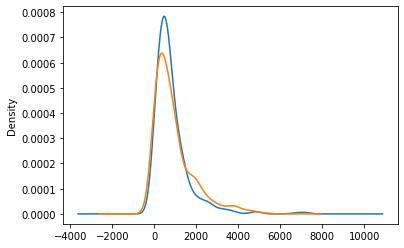

In [9]:
pheno.query('Diagnosis=="Lung Adenocarcinoma"')['Time To Event From Diagnosis (Days)'].plot.kde()
pheno.query('Diagnosis=="Lung Squamous Cell Carcinoma"')['Time To Event From Diagnosis (Days)'].plot.kde()

In [12]:
#pheno[['Overall Survival Status', 'Time To Overall Survival (Days)', 'Tumor Stage']]

# Firstly bi-nominally: what is per tumor stage the probability of death?


In [19]:
stage_map = {'stage i': 'stage 1', 'stage ia': 'stage 1', 'stage ib': 'stage 1',
             'stage ii': 'stage 2', 'stage iia': 'stage 2', 'stage iib': 'stage 2',
             'stage iii': 'stage 3','stage iiia': 'stage 3', 'stage iiib': 'stage 3',
             'stage iv' : 'stage 4'}
pheno['Stage'] = pheno['Tumor Stage'].map(stage_map)

In [21]:
pheno[['Overall Survival Status', 'Stage']].groupby('Stage').aggregate(['mean', 'count'])

Overall Survival Status      
                           mean count
Stage                                
stage 1                0.323160   557
stage 2                0.410959   292
stage 3                0.544379   169
stage 4                0.636364    33

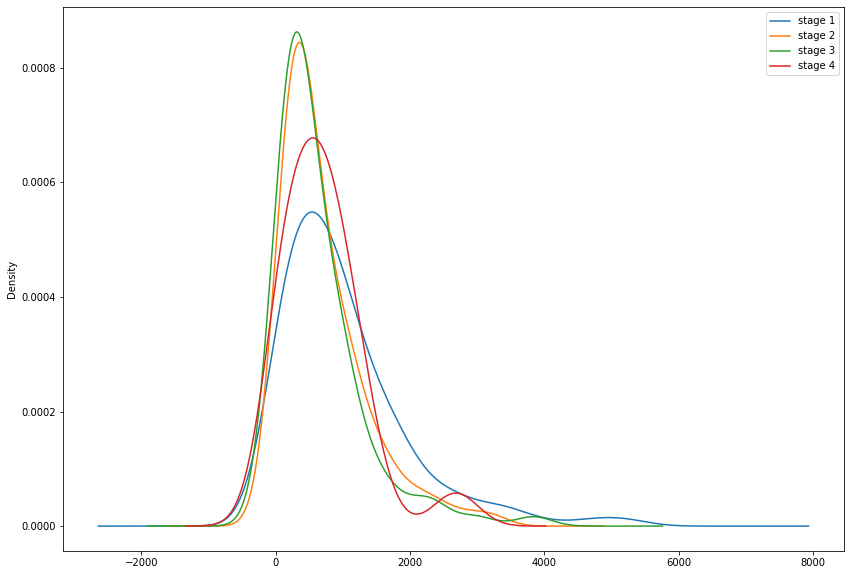

In [29]:
pheno.loc[(pheno['Overall Survival Status']==1) & 
           (pheno['Stage']=='stage 1')]['Time To Overall Survival (Days)'].plot.kde(figsize=(14,10), label='stage 1')
pheno.loc[(pheno['Overall Survival Status']==1) & 
           (pheno['Stage']=='stage 2')]['Time To Overall Survival (Days)'].plot.kde(label='stage 2')
pheno.loc[(pheno['Overall Survival Status']==1) & 
           (pheno['Stage']=='stage 3')]['Time To Overall Survival (Days)'].plot.kde(label='stage 3')
pheno.loc[(pheno['Overall Survival Status']==1) & 
           (pheno['Stage']=='stage 4')]['Time To Overall Survival (Days)'].plot.kde(label='stage 4')
plt.legend()

# Kaplan Meier curves

In [71]:
def survival(x):
    s = 1
    times = x.sort_values('Time To Overall Survival (Days)')['Time To Overall Survival (Days)'].unique().tolist()
    res = []
    tot_patients = x.shape[0]
    dcountSum = 0
    for _t in times:        
        dcount = x.loc[x['Time To Overall Survival (Days)']==_t]['Overall Survival Status'].sum()
        dcountSum += dcount
        lcount = tot_patients - dcountSum
        s = s*(1-dcount/lcount)
        res.append({'t': _t, 's': s})
    return pd.DataFrame(res)

In [94]:
pheno.Diagnosis.unique()

array(['Lung Adenocarcinoma', nan, 'Lung Squamous Cell Carcinoma'],
      dtype=object)

In [89]:
smoke_map = {'Current Reformed Smoker < or = 15 yrs': 'reformed', 
             'Current Reformed Smoker for > 15 yrs': 'reformed',
             'Current Reformed Smoker, Duration Not Specified': 'reformed',
             'Current Smoker': 'current',
             'Lifelong Non-Smoker': 'non-smoker'}
pheno['Smoking'] = pheno['Smoking Status'].map(smoke_map)

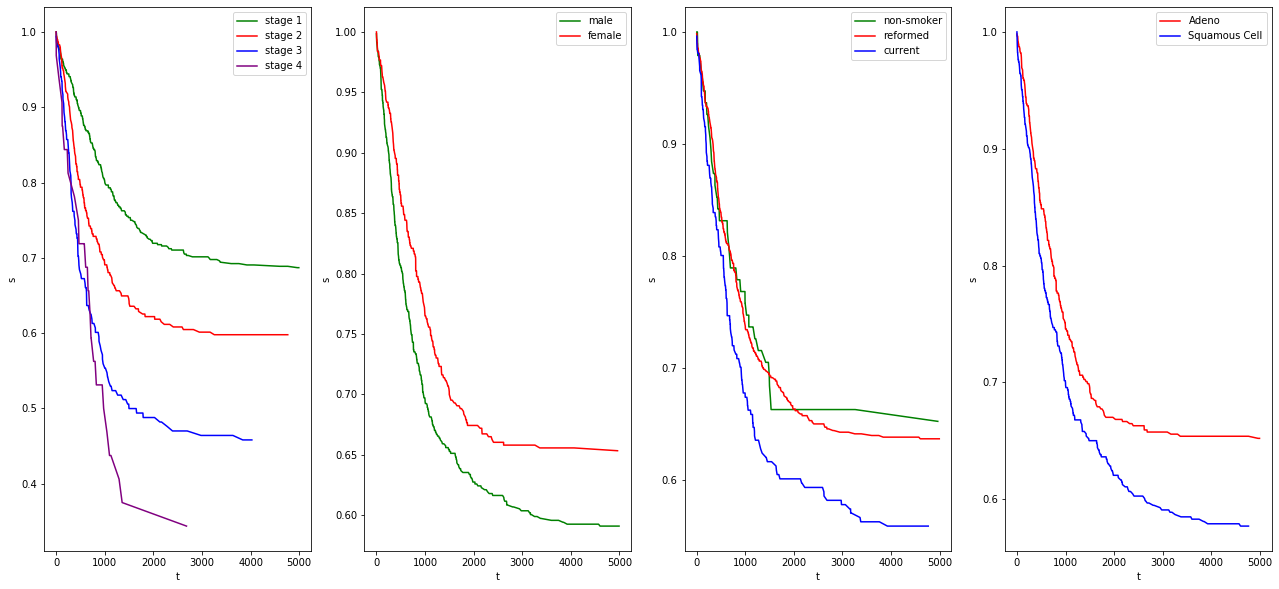

In [96]:
# Gender (male/female), stage 1/2/3/4
#df = survival(pheno[['Time To Overall Survival (Days)', 'Overall Survival Status']])
#sns.lineplot(data=df, x='t' , y='s', color='black')

fig, ax = plt.subplots(figsize=(22,10), ncols=4)

max_days = 5000

df = survival(pheno.query('Stage=="stage 1"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='green', label='stage 1', ax=ax[0])

df = survival(pheno.query('Stage=="stage 2"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='red', label='stage 2', ax=ax[0])

df = survival(pheno.query('Stage=="stage 3"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='blue', label='stage 3', ax=ax[0])

df = survival(pheno.query('Stage=="stage 4"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='purple', label='stage 4', ax=ax[0])
ax[0].legend()

#######################

df = survival(pheno.query('Gender=="male"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='green', label='male', ax=ax[1])

df = survival(pheno.query('Gender=="female"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='red', label='female', ax=ax[1])
ax[1].legend()

#######################

df = survival(pheno.query('Smoking=="non-smoker"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='green', label='non-smoker', ax=ax[2])

df = survival(pheno.query('Smoking=="reformed"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='red', label='reformed', ax=ax[2])

df = survival(pheno.query('Smoking=="current"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='blue', label='current', ax=ax[2])
ax[2].legend()

#######################

df = survival(pheno.query('Diagnosis=="Lung Adenocarcinoma"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='red', label='Adeno', ax=ax[3])

df = survival(pheno.query('Diagnosis=="Lung Squamous Cell Carcinoma"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
sns.lineplot(data=df.loc[df.t<max_days], x='t' , y='s', color='blue', label='Squamous Cell', ax=ax[3])
ax[3].legend()


In [103]:
df1 = survival(pheno.query('Diagnosis=="Lung Adenocarcinoma"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
df2 = survival(pheno.query('Diagnosis=="Lung Squamous Cell Carcinoma"')[['Time To Overall Survival (Days)', 'Overall Survival Status']])
# separation score
# integration of relative differences

# Hazard ratio
def hazardratio():
    
#log-rank test
def logrank(x1, x2):
    
#mwu


In [ ]:
# apply to all genes, split by median -> x1, x2

# Cox regression

# Immunoresponse clustering

In [102]:
immuno_response = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/immunodata.csv", sep="\s+", engine="python")

ParserError: Expected 54 fields in line 10, saw 58. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.